<a href="https://colab.research.google.com/github/Solxcero/My_AI_World/blob/main/DeepLearning/04_%ED%85%8D%EC%8A%A4%ED%8A%B8%EB%B6%84%EB%A5%98.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

감정분류


# 캐글 API 설정

In [ ]:
# %cd /content
!pip install kaggle
from google.colab import files
files.upload()

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"solxcero","key":"8a9da598921213b50c31ef71f993050b"}'}

In [ ]:
!ls -1ha kaggle.json

kaggle.json


In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
# Permission Warning이 발생하지 않도록 해줍니다.
# !chmod 600 ~/.kaggle/kaggle.json
# # 내가 참가한 대회 리스트 확인
# !kaggle competitions list

In [ ]:
!kaggle competitions download -c word2vec-nlp-tutorial

403 - Forbidden


In [ ]:
!kaggle datasets download -d ymanojkumar023/kumarmanoj-bag-of-words-meets-bags-of-popcorn

 99% 52.0M/52.4M [00:04<00:00, 15.4MB/s]
100% 52.4M/52.4M [00:04<00:00, 13.0MB/s]


In [ ]:
!ls

drive	     kumarmanoj-bag-of-words-meets-bags-of-popcorn.zip
kaggle.json  sample_data


In [ ]:
# %cd /content

/content


In [ ]:
!unzip kumarmanoj-bag-of-words-meets-bags-of-popcorn.zip

Archive:  kumarmanoj-bag-of-words-meets-bags-of-popcorn.zip
  inflating: labeledTrainData.tsv    
  inflating: sampleSubmission.csv    
  inflating: testData.tsv            
  inflating: unlabeledTrainData.tsv  


In [ ]:
!mkdir data_in

In [ ]:
!mv labeledTrainData.tsv sampleSubmission.csv testData.tsv unlabeledTrainData.tsv /content/data_in

# 데이터 분석 및 전처리

1. 캐글 데이터 불러오기
2. EDA
3. 데이터 정제
> HTML 및 문장 부호 제거  
불용어 제거  
단어 최대 길이 설정  
단어 패딩  
벡터 표상화   
4. 모델링

## 라이브러리

In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

from tqdm import tqdm

## 데이터 분석  
1. 데이터 크기
2. 데이터의 개수
3. 각 리뷰의 문자 길이 분포
4. 많이 사용된 단어
5. 긍정, 부정의 데이터 분포
6. 각 리뷰의 단어 개수 분포
7. 특수문자 및 대문자, 소문자 비율

In [ ]:
DATA_IN_PATH = '/content/data_in/'
train = pd.read_csv('/content/data_in/labeledTrainData.tsv',header=0, delimiter='\t',quoting=3) #quating=3 :쌍따옴표 무시
train

,id,sentiment,review
0,"""5814_8""",1,"""With all this stuff going down at the moment ..."
1,"""2381_9""",1,"""\""The Classic War of the Worlds\"" by Timothy ..."
2,"""7759_3""",0,"""The film starts with a manager (Nicholas Bell..."
3,"""3630_4""",0,"""It must be assumed that those who praised thi..."
4,"""9495_8""",1,"""Superbly trashy and wondrously unpretentious ..."
...,...,...,...
24995,"""3453_3""",0,"""It seems like more consideration has gone int..."
24996,"""5064_1""",0,"""I don't believe they made this film. Complete..."
24997,"""10905_3""",0,"""Guy is a loser. Can't get girls, needs to bui..."
24998,"""10194_3""",0,"""This 30 minute documentary Buñuel made in the..."


In [ ]:
print('파일 크기 : ')
for file in os.listdir(DATA_IN_PATH):
    if 'tsv' in file and 'zip' not in file : 
        print(file.ljust(30) + str(round(os.path.getsize(DATA_IN_PATH + file)/1000000,2))+'MB')

파일 크기 : 
testData.tsv                  32.72MB
labeledTrainData.tsv          33.56MB
unlabeledTrainData.tsv        67.28MB


In [ ]:
print(f'전체 학습 데이터 개수 : {len(train)}')

전체 학습 데이터 개수 : 25000


In [ ]:
train_len = train['review'].apply(len)
train_len
# 각 리뷰의 길이 

0        2304
1         948
2        2451
3        2247
4        2233
         ... 
24995     582
24996     977
24997     643
24998    1143
24999     944
Name: review, Length: 25000, dtype: int64

Text(0, 0.5, 'Number of review')

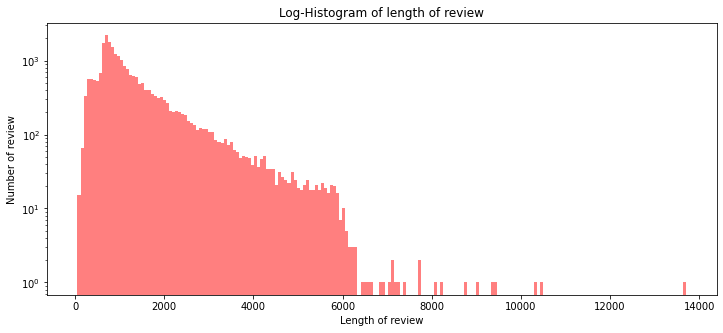

In [ ]:
plt.figure(figsize=(12,5))
plt.hist(train_len, bins=200, alpha=0.5, color='r',label='word')
plt.yscale('log',nonposy='clip')
plt.title('Log-Histogram of length of review')
plt.xlabel('Length of review')
plt.ylabel('Number of review')

#이상치 확인 

In [ ]:
print(f'리뷰 길이 최댓값 : {np.max(train_len)}')
print(f'리뷰 길이 최솟값 : {np.min(train_len)}')
print(f'리뷰 길이 평균값 : {np.mean(train_len)}')
print(f'리뷰 길이 표준편차 : {np.std(train_len)}')
print(f'리뷰 길이 중앙값 : {np.median(train_len)}')
print(f'리뷰 길이 제1사분위 : {np.percentile(train_len, 25)}')
print(f'리뷰 길이 제3사분위 : {np.percentile(train_len,75)}')

리뷰 길이 최댓값 : 13710
리뷰 길이 최솟값 : 54
리뷰 길이 평균값 : 1329.71056
리뷰 길이 표준편차 : 1005.2191407969142
리뷰 길이 중앙값 : 983.0
리뷰 길이 제1사분위 : 705.0
리뷰 길이 제3사분위 : 1619.0


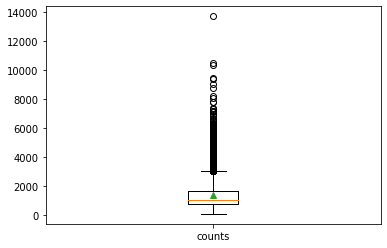

In [ ]:
plt.boxplot(train_len, labels=['counts'],showmeans=True)
plt.show()

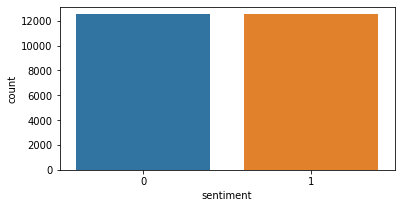

Pos Review : 12500
Neg Review : 12500


In [ ]:
fig,axe = plt.subplots(ncols=1)
fig.set_size_inches(6,3)
sns.countplot(train['sentiment'])
plt.show()

print(f'Pos Review : {train.sentiment.value_counts()[1]}')
print(f'Neg Review : {train.sentiment.value_counts()[0]}')

리뷰당 단어의 수 확인

In [ ]:
train_word_cnt = train['review'].apply(lambda x : len(x.split(' '))) # 띄어쓰기 기준으로 단어 구분
train_word_cnt

0        433
1        158
2        378
3        379
4        367
        ... 
24995     95
24996    174
24997    127
24998    197
24999    184
Name: review, Length: 25000, dtype: int64

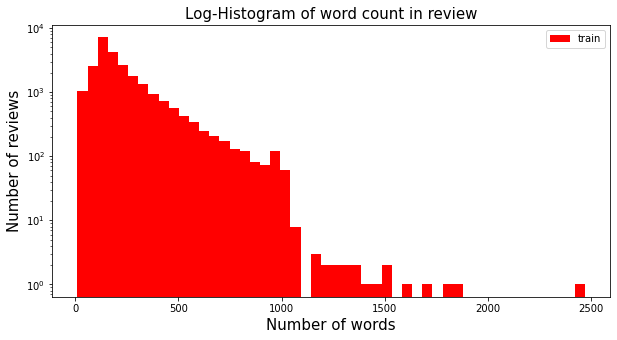

In [ ]:
plt.figure(figsize=(10,5))
plt.hist(train_word_cnt, bins=50, facecolor='r',label='train')
plt.title('Log-Histogram of word count in review',fontsize=15)
plt.yscale('log',nonposy='clip')
plt.legend()
plt.xlabel('Number of words',fontsize=15)
plt.ylabel('Number of reviews',fontsize=15)
plt.show()

In [ ]:
print(f'리뷰 단어 개수 최댓값 : {np.max(train_word_cnt)}')
print(f'리뷰 단어 개수 최솟값 : {np.min(train_word_cnt)}')
print(f'리뷰 단어 개수 평균값 : {np.mean(train_word_cnt)}')
print(f'리뷰 단어 개수 표준편차 : {np.std(train_word_cnt)}')
print(f'리뷰 단어 개수 중앙값 : {np.median(train_word_cnt)}')
print(f'리뷰 단어 개수 제1사분위 : {np.percentile(train_word_cnt, 25)}')
print(f'리뷰 단어 개수 제3사분위 : {np.percentile(train_word_cnt,75)}')

리뷰 단어 개수 최댓값 : 2470
리뷰 단어 개수 최솟값 : 10
리뷰 단어 개수 평균값 : 233.78624
리뷰 단어 개수 표준편차 : 173.74237015380675
리뷰 단어 개수 중앙값 : 174.0
리뷰 단어 개수 제1사분위 : 127.0
리뷰 단어 개수 제3사분위 : 284.0


구두점과 대소문자 비율 확인하기  
> 전처리 과정에서 대문자의 경우 모두 소문자로 바꾸고, 특수문자 제거

In [ ]:
qmarks = np.mean(train['review'].apply(lambda x : '?' in x))
fullstop = np.mean(train['review'].apply(lambda x : '.' in x))
capital_first = np.mean(train['review'].apply(lambda x : x[0].isupper()))
capitals = np.mean(train['review'].apply(lambda x : max([y.isupper() for y in x]))) # 대문자 개수
numbers = np.mean(train['review'].apply(lambda x : max([y.isdigit() for y in x]))) #숫자 개수


print(f'물음표가 있는 문장 : {qmarks*100:.2f}%')
print(f'마침표가 있는 질문 : {fullstop*100:.2f}%')
print(f'첫 글자가 대문자인 문장 : {capital_first*100:.2f}%')
print(f'대문자가 있는 문장 : {capitals*100:.2f}% ')
print(f'숫자가 있는 문장 : {numbers*100:.2f}%')

물음표가 있는 문장 : 29.55%
마침표가 있는 질문 : 99.69%
첫 글자가 대문자인 문장 : 0.00%
대문자가 있는 문장 : 99.59% 
숫자가 있는 문장 : 56.66%


In [ ]:
train[train['review'].apply(lambda x : '?' in x)]

In [ ]:
train[train['review'].apply(lambda x : max([y.isdigit() for y in x]))]

## 전처리

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
import pandas as pd
import numpy
import json
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

In [ ]:
train['review'][0]

'"With all this stuff going down at the moment with MJ i\'ve started listening to his music, watching the odd documentary here and there, watched The Wiz and watched Moonwalker again. Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent. Moonwalker is part biography, part feature film which i remember going to see at the cinema when it was originally released. Some of it has subtle messages about MJ\'s feeling towards the press and also the obvious message of drugs are bad m\'kay.<br /><br />Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring. Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him.<br /><br />The actual feature film bit when it finally

In [ ]:
review = train['review'][0]
review_text = BeautifulSoup(review,'html5lib').get_text() #HTML 태그 제거
review_text = re.sub("[^a-zA-Z]"," ",review_text) #영어 문자를 제외한 나머지 모두 공백으로 
review_text

' With all this stuff going down at the moment with MJ i ve started listening to his music  watching the odd documentary here and there  watched The Wiz and watched Moonwalker again  Maybe i just want to get a certain insight into this guy who i thought was really cool in the eighties just to maybe make up my mind whether he is guilty or innocent  Moonwalker is part biography  part feature film which i remember going to see at the cinema when it was originally released  Some of it has subtle messages about MJ s feeling towards the press and also the obvious message of drugs are bad m kay Visually impressive but of course this is all about Michael Jackson so unless you remotely like MJ in anyway then you are going to hate this and find it boring  Some may call MJ an egotist for consenting to the making of this movie BUT MJ and most of his fans would say that he made it for the fans which if true is really nice of him The actual feature film bit when it finally starts is only on for    m

In [ ]:
#불용어 제거 
stop_words = set(stopwords.words('english'))

review_text = review_text.lower() # 불용어처리 전에 모두 소문자로 바꿔야 함
words = review_text.split()
words = [w for w in words if not w in stop_words] #불용어가 아닌 단어 리스트로 저장
words[:10]


['stuff',
 'going',
 'moment',
 'mj',
 'started',
 'listening',
 'music',
 'watching',
 'odd',
 'documentary']

In [ ]:
clean_review = " ".join(words)
clean_review #불용어 제거한 후의 리뷰

'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate workin

In [ ]:
def preprocessing(review, remove_stopwords=False):
    #불용어 제거 여부는 옵션으로 걸기

    # 1.HTML 태그 제거
    review_text = BeautifulSoup(review, "html5lib").get_text()

    # 2.영어가 아닌 특수문자 공백 대체
    review_text = re.sub("[^a-zA-Z]"," ",review_text)

    # 3.모두 소문자로 바꾼 뒤 공백단위로 나누기
    words = review_text.lower().split()

    if remove_stopwords : 
        # 4.불용어 제거

        # 영어 불용어 가져오기
        stop = set(stopwords.words("english"))
        # 불용어 아닌 단어들
        words = [w for w in words if not w in stop]
        # 클린 데이터 만들기
        clean_review = ' '.join(words)
    
    else :
        clean_review = ' '.join(words) 
    
    return clean_review

In [ ]:
clean_train = []
for review in tqdm(train['review'],desc='cleansing'):
    clean_train.append(preprocessing(review,remove_stopwords=True))

cleansing: 100%|██████████| 25000/25000 [00:22<00:00, 1096.61it/s]


In [ ]:
clean_train[0]

'stuff going moment mj started listening music watching odd documentary watched wiz watched moonwalker maybe want get certain insight guy thought really cool eighties maybe make mind whether guilty innocent moonwalker part biography part feature film remember going see cinema originally released subtle messages mj feeling towards press also obvious message drugs bad kay visually impressive course michael jackson unless remotely like mj anyway going hate find boring may call mj egotist consenting making movie mj fans would say made fans true really nice actual feature film bit finally starts minutes excluding smooth criminal sequence joe pesci convincing psychopathic powerful drug lord wants mj dead bad beyond mj overheard plans nah joe pesci character ranted wanted people know supplying drugs etc dunno maybe hates mj music lots cool things like mj turning car robot whole speed demon sequence also director must patience saint came filming kiddy bad sequence usually directors hate workin

In [ ]:
clean_train_df = pd.DataFrame({'review':clean_train, 'sentiment':train['sentiment']})
clean_train_df

,review,sentiment
0,stuff going moment mj started listening music ...,1
1,classic war worlds timothy hines entertaining ...,1
2,film starts manager nicholas bell giving welco...,0
3,must assumed praised film greatest filmed oper...,0
4,superbly trashy wondrously unpretentious explo...,1
...,...,...
24995,seems like consideration gone imdb reviews fil...,0
24996,believe made film completely unnecessary first...,0
24997,guy loser get girls needs build picked stronge...,0
24998,minute documentary bu uel made early one spain...,0


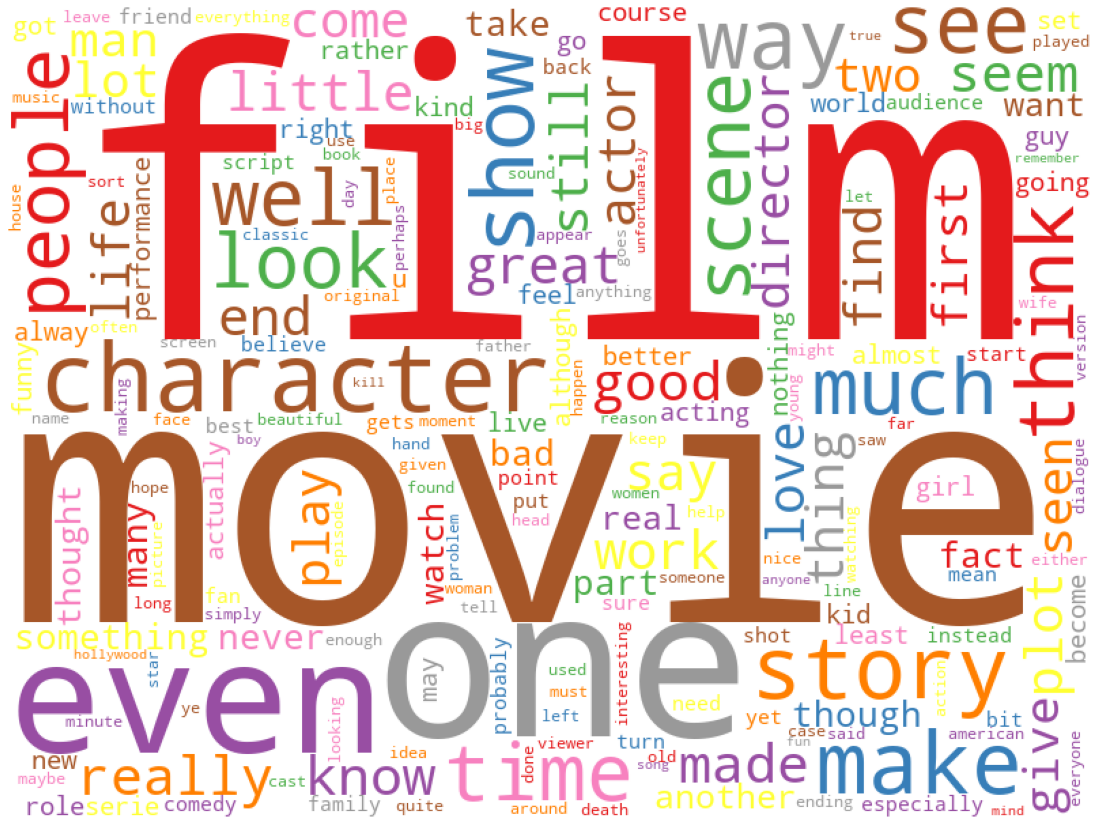

In [ ]:
from wordcloud import WordCloud

cloud = WordCloud(width=800, height=600,background_color='white',colormap='Set1').generate(" ".join(clean_train_df['review']))
plt.figure(figsize=(20,15))
plt.imshow(cloud)
plt.axis('off')
plt.show()

모델에 학습시키기 위해 단어를 인덱스로 구성된 벡터로 변환

### 단어 사전 만들기

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(clean_train)
text_sequences = tokenizer.texts_to_sequences(clean_train)

In [ ]:
list(zip(text_sequences[0],clean_train[0].split()))
#각 단어가 인덱스로 변환됨

[(404, 'stuff'),
 (70, 'going'),
 (419, 'moment'),
 (8815, 'mj'),
 (506, 'started'),
 (2456, 'listening'),
 (115, 'music'),
 (54, 'watching'),
 (873, 'odd'),
 (516, 'documentary'),
 (178, 'watched'),
 (18686, 'wiz'),
 (178, 'watched'),
 (11242, 'moonwalker'),
 (165, 'maybe'),
 (78, 'want'),
 (14, 'get'),
 (662, 'certain'),
 (2457, 'insight'),
 (117, 'guy'),
 (92, 'thought'),
 (10, 'really'),
 (499, 'cool'),
 (4074, 'eighties'),
 (165, 'maybe'),
 (22, 'make'),
 (210, 'mind'),
 (581, 'whether'),
 (2333, 'guilty'),
 (1194, 'innocent'),
 (11242, 'moonwalker'),
 (71, 'part'),
 (4826, 'biography'),
 (71, 'part'),
 (635, 'feature'),
 (2, 'film'),
 (253, 'remember'),
 (70, 'going'),
 (11, 'see'),
 (302, 'cinema'),
 (1663, 'originally'),
 (486, 'released'),
 (1144, 'subtle'),
 (3265, 'messages'),
 (8815, 'mj'),
 (411, 'feeling'),
 (793, 'towards'),
 (3342, 'press'),
 (17, 'also'),
 (441, 'obvious'),
 (600, 'message'),
 (1500, 'drugs'),
 (15, 'bad'),
 (4424, 'kay'),
 (1851, 'visually'),
 (998, '

In [ ]:
# 단어 사전 만들기
# 단어와 해당 단어의 인덱스 확인
word_vocab = tokenizer.word_index
word_vocab["<PAD>"] = 0

In [ ]:
print(f'전체 단어 개수 : {len(word_vocab)}')

전체 단어 개수 : 74066


In [ ]:
# 단어사전뿐 아니라 단어 개수도 이후 모델에서 사용되기 때문에 저장
# 데이터에 대한 정보인 단어 사전과 단어 개수는 새롭게 딕셔러니로 저장

data_configs = {}
data_configs['vocab'] = word_vocab
data_configs['vocab_size'] = len(word_vocab)

### 패딩

In [ ]:
MAX_SEQUENCE_LENGTH = 174 # 문장 최대 길이 지정  -> 단어 개수 중앙값
train_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH,padding='pre') # 0을 뒤에 채워줌 / 시계열 분석이 아니라면 뒤에 채워서 문장 위치 맞추기
print(f'Shape of train data : {train_inputs.shape}')

Shape of train data : (25000, 174)


In [ ]:
# 라벨 값을 넘파이 배열로 저장. 
# 이후 전처리한 데이터를 저장할 떄 넘파이 형태로 저장하기 때문
train_labels = np.array(train['sentiment'])
print(f'Shape of label tensor : {train_labels.shape}')

#데이터 하나 당 하나의 값을 가지는 형태. 

Shape of label tensor : (25000,)


# 데이터 저장
1. 정제된 텍스트 데이터 (csv)
2. 벡터화된 데이터 (numpy)
3. 정답 라벨 (numpy)
4. 데이터 정보(단어 사전, 전체 단어 개수) (JSON)

In [ ]:
DATA_PATH_IN = './data_in/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
TRAIN_CLEAN_DATA = 'train_clean.csv'
DATA_CONFIGS = 'data_configs.json'

import os
if not os.path.exists(DATA_PATH_IN):
    os.makedirs(DATA_PATH_IN)

In [ ]:
np.save(open(DATA_PATH_IN+TRAIN_INPUT_DATA,'wb'),train_inputs)
np.save(open(DATA_PATH_IN+TRAIN_LABEL_DATA,'wb'),train_labels)

clean_train_df.to_csv(DATA_PATH_IN + TRAIN_CLEAN_DATA, index=False)

json.dump(data_configs,open(DATA_IN_PATH + DATA_CONFIGS,'w'),ensure_ascii=False)

In [ ]:
train_inputs

array([[    0,     0,     0, ...,  4064,  3831,   771],
       [    0,     0,     0, ...,     6,  3046,  1347],
       [    0,     0,     0, ...,   297, 20131,   332],
       ...,
       [    0,     0,     0, ...,   167,     9,   444],
       [    0,     0,     0, ...,   166,    37, 10439],
       [    0,     0,     0, ...,   119,  1561,     3]], dtype=int32)

# TEST DATA

In [ ]:
test = pd.read_csv('/content/data_in/testData.tsv',header=0, delimiter='\t',quoting=3)
clean_test_reviews = []

for review in tqdm(test['review'],desc='cleansing'):
    clean_test_reviews.append(preprocessing(review, remove_stopwords=True))
clean_test_df = pd.DataFrame({'review' : clean_test_reviews, 'id': test['id']})
test_id = np.array(test['id'])

text_sequences = tokenizer.texts_to_sequences(clean_test_reviews)
test_inputs = pad_sequences(text_sequences, maxlen=MAX_SEQUENCE_LENGTH, padding='post')

In [ ]:
TEST_INPUT_DATA = 'test_input.npy'
TEST_CLEAN_DATA = 'test_clean.csv'
TEST_ID_DATA = 'test_id.npy'

np.save(open(DATA_IN_PATH + TEST_INPUT_DATA, 'wb'),test_inputs)
np.save(open(DATA_IN_PATH + TEST_ID_DATA, 'wb'),test_id)
clean_test_df.to_csv(DATA_IN_PATH + TEST_CLEAN_DATA,index=False)

In [ ]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [ ]:
!cp -r /content/data_in ./1.NLP/bag_of_words_popcorn/

# 모델링(딥러닝 사용 X)

## 임베딩 : TF-IDF
**`TF(Term Frequency)`** : 특정 단어가 하나의 데이터 안에서 등장하는 횟수  
**`DF(Document Frequency)`** :  문서 빈도 값. 특정 단어가 여러 데이터에 자주 등장하는지 알려조는 지표   
**`IDF(Inverse DF)`** :  DF의 역수 . 특정 단어가 다른 데이터에 등장하지 않을수록 값이 커짐  
**`TF-IDF`** :  TF와 IDF을 곱해서 사용하므로 어떤 단어가 해당 문서에 자주 등장하지만 다른 문서에는 많이 없는 단어일수록 높은 값을 가지게 됨  
> 조사나 지시대명사처럼 자주 등장하는 단어는 TF값은 크지만  IDF 값은 작아지므로 CounterVectorizer 가 가진 문제점을 해결해줌


In [ ]:
DATA_IN_PATH = './data_in/'
TRAIN_CLEAN_DATA = 'train_clean.csv'

# 입력값이 텍스트로 이뤄진 데이터 형태여야 하므로 전처리 데이터 중 넘파이 배열이 아닌 정제된 텍스트 데이터 사용

train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1.NLP/bag_of_words_popcorn/data_in/train_clean.csv')
reviews = list(train_data['review'])
sentiments = list(train_data['sentiment'])


[파라미터 설정](https://chan-lab.tistory.com/27)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(min_df = 0.0, analyzer = 'char',sublinear_tf=True,ngram_range=(1,3),max_features=5000)

X = vectorizer.fit_transform(reviews)

In [ ]:
X.toarray()

array([[0.05466041, 0.02721204, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06989814, 0.02794051, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.04775464, 0.02960817, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.08995747, 0.04787827, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.06461954, 0.02506215, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.07674428, 0.03537221, 0.        , ..., 0.        , 0.        ,
        0.        ]])

## 임베딩 : word2vec

|파라미터|설명|
|---|---|
|`size`|각 단어에 대해 임베딩된 벡터의 차원을 정함|
|`min_count`|모델에 의미 단어를 가지고 학습하기 위해 적은 빈도 수의 단어들은 학습하지 않음|
|`worekrs`|모델 학습 시 학습을 위한 프로세스 개수 지정|
|`window`|word2vec을 수행하기 위한 컨텍스트 윈도 크기를 지정|
|`sampling`|word2vec 학습을 수행할 때 빠른 학습을 위해 정담 단어 라벨에 대한 다운 샘플링 비율을 지정. 보통 0.001이 좋은 성능을 낸다고 함|

In [ ]:
DATA_IN_PATH = './data_in/'
TRAIN_CLEAN_DATA = 'train_clean.csv'

# 단어로 표현된 리스트를 입력값으로 넣어야 하므로 넘파이 배열이 아닌 테스트 데이터 사용

train_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/1.NLP/bag_of_words_popcorn/data_in/train_clean.csv')
reviews = list(train_data['review'])
sentiments = list(train_data['sentiment'])

sentences = []
for review in tqdm(reviews,desc='sentences') :
    sentences.append(review.split())

# 각 리뷰가 하나의 문자열로 이루어져 있기 때문에 입력값들을 단어로 구분된 리스트로 만들어야 함 

sentences: 100%|██████████| 25000/25000 [00:00<00:00, 40539.94it/s]


In [ ]:
#학습시 필요한 파라미터 
num_features = 300     # 워드 벡터 특징값 수 
min_word_count = 400   # 단어에 대한 최소 빈도 수 
num_workers = 4        # 프로세스 개수
context = 10           # 컨텍스트 윈도 크기
downsampling = 1e-3    # 다운 샘플링 비율

In [ ]:
import logging

logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

from gensim.models import word2vec

print('Training........')
model = word2vec.Word2Vec(sentences, workers=num_workers, size=num_features, min_count = min_word_count, 
                          window = context, sample = downsampling)

Training........


In [ ]:
model_name = '300features_40minwords_10context'
model.save('/content/drive/MyDrive/Colab Notebooks/1.NLP/'+model_name)

각 리뷰마다 단어의 개수가 다름.  
입력값을 하나의 형태로 맞춰야 함. -> 문장에 있는 모든 단의 벡터값에 대해 평균을 내서 리뷰 하나당 하나의 벡터로 만들기 

In [ ]:
def get_features(words, model, num_features):
    #출력 벡터 초기화
    feature_vector = np.zeros((num_features),dtype=np.float32)

    num_words = 0 
    # 어휘 사전 준비
    index2word_set = set(model.wv.index2word)

    for w in words :
        if w in index2word_set :
            num_words+=1
            #사전에 해당하는 단어에 대해 단어 벡터 더함
            feature_vector = np.add(feature_vector,model[w])

    # 문장의 단어 수만큼 나누어 단어 벡터의 평균값을 문장 벡터로 함
    feature_vector = np.divide(feature_vector,num_words)
    return feature_vector



1. 하나의 벡터를 만드는 과정에서 속도를 빠르게 하기 위해 np.zeros를 사용해 미리 모두 0의 값을 가지는 벡터를 만듦  
2. 그리고 단어가 해당 모델 사전에 속하는지 보기 위해 `model.wv.index2word`를 set 객체로 생성해서  index2word_set 변수에 할당 
3. 반복문을 통해 리뷰를 구성하는 단어에 대해 임베딩된 벡터가 있는 단어 벡터의 합을 구함
4. 사용한 단어의 전체 개수로 나눔으로써 평균 벡터의 값을 구함

In [ ]:
def get_dataset(reviews, model, num_features):
    dataset = list()

    for s in reviews : 
        dataset.append(get_features(s,model, num_features))

    reviewFeatureVecs = np.stack(dataset)

    return reviewFeatureVecs

In [ ]:
test_data_vecs = get_dataset(sentences,model, num_features)

In [ ]:
test_data_vecs

array([[-0.1794021 ,  0.0912624 , -0.16016068, ...,  0.13178986,
        -0.07603395, -0.01653919],
       [-0.09537528,  0.11949226, -0.11715697, ...,  0.0509913 ,
        -0.00722649,  0.00721816],
       [ 0.08296338,  0.02105824, -0.08027171, ...,  0.01042633,
         0.16021097,  0.11234923],
       ...,
       [-0.02531359,  0.07417087, -0.13542065, ...,  0.18075892,
        -0.22288865, -0.09979951],
       [ 0.02255063,  0.04439311, -0.00598144, ..., -0.01555918,
        -0.09989002, -0.09367936],
       [-0.01821631,  0.09783226, -0.00809313, ...,  0.09697324,
        -0.1469159 ,  0.07459659]], dtype=float32)

# RNN(순환 신경망 분류 모델)
1. 문장 데이터를 입력해서 문장 흐름에서 패턴을 찾아 분류하게 함
2. 단어 특징 벡터를 사용하지 않고, 텍스트 정보를 입력해서 문장에 대한 특징 정보를 추출

In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras import layers

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import json

from tqdm import tqdm

In [ ]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

In [ ]:
# 랜덤 시드 고정
SEED_NUM = 1234
tf.random.set_seed(SEED_NUM)

## 데이터 불러오기

In [ ]:
# %cd /content
%cd /content/drive/MyDrive/Colab Notebooks/1.NLP/bag_of_words_popcorn

/content/drive/MyDrive/Colab Notebooks/1.NLP/bag_of_words_popcorn


In [ ]:
DATA_IN_PATH = './data_in/'
DATA_OUT_PATH = './data_out/'
TRAIN_INPUT_DATA = 'train_input.npy'
TRAIN_LABEL_DATA = 'train_label.npy'
DATA_CONFIGS = 'data_configs.json'

train_input = np.load(open(DATA_IN_PATH + TRAIN_INPUT_DATA, 'rb'))
# train_input = train_inputs
train_label = np.load(open(DATA_IN_PATH + TRAIN_LABEL_DATA, 'rb'))
prepro_configs = json.load(open(DATA_IN_PATH + DATA_CONFIGS, 'r'))

In [ ]:
train_input

array([[  411,   793,  3342, ..., 18689,   316,  1356],
       [  232,   203,  3048, ...,     0,     0,     0],
       [ 1416,  2366,  1362, ...,   700,  1175,  5310],
       ...,
       [  117,  3104,    14, ...,     0,     0,     0],
       [  639,   516, 16593, ...,     0,     0,     0],
       [  109,     1,   350, ...,     0,     0,     0]], dtype=int32)

In [ ]:
# pad_sequences(train_input, padding='pre',maxlen = train_input.shape[1])

## 모델 하이퍼파라미터

In [ ]:
model_name = 'rnn_classifier_en'
BATCH_SIZE = 128
NUM_EPOCHS = 5
VALID_SPLIT = 0.1
MAX_LEN = train_input.shape[1]

# __init__함수에 적용하기 위함
kargs = {'model_name': model_name,
        'vocab_size': prepro_configs['vocab_size'],
        'embedding_dimension': 100,
        'dropout_rate': 0.2,
        'lstm_dimension': 150,
        'dense_dimension': 150,
        'output_dimension':1}

## 모델 구현

In [ ]:
class RNNClassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(RNNClassifier, self).__init__(name=kargs['model_name'])
        self.embedding = layers.Embedding(input_dim=kargs['vocab_size'],
                                     output_dim=kargs['embedding_dimension'])
        self.lstm_1_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_2_layer = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        self.dropout = layers.Dropout(kargs['dropout_rate'])
        self.fc1 = layers.Dense(units=kargs['dense_dimension'],
                           activation=tf.keras.activations.tanh)
        self.fc2 = layers.Dense(units=kargs['output_dimension'],
                           activation=tf.keras.activations.sigmoid)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)
        x = self.lstm_1_layer(x)
        x = self.lstm_2_layer(x)
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        
        return x

In [ ]:
model = RNNClassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy(name='accuracy')])

## Callback 선언

In [ ]:
# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001, patience=1)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)

checkpoint_path = DATA_OUT_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create path if exists
if os.path.exists(checkpoint_dir):
    print("{} -- Folder already exists \n".format(checkpoint_dir))
else:
    os.makedirs(checkpoint_dir, exist_ok=True)
    print("{} -- Folder create complete \n".format(checkpoint_dir))
    

cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

./data_out/rnn_classifier_en -- Folder already exists 



In [ ]:
history = model.fit(train_input, train_label, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,
                    validation_split=VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

Epoch 1/5
175/176 [============================>.] - ETA: 0s - loss: 0.6931 - accuracy: 0.5080
Epoch 1: val_accuracy improved from -inf to 0.51040, saving model to ./data_out/rnn_classifier_en/weights.h5
176/176 [==============================] - 11s 47ms/step - loss: 0.6931 - accuracy: 0.5076 - val_loss: 0.6929 - val_accuracy: 0.5104
Epoch 2/5
176/176 [==============================] - ETA: 0s - loss: 0.6918 - accuracy: 0.5142
Epoch 2: val_accuracy did not improve from 0.51040
176/176 [==============================] - 7s 39ms/step - loss: 0.6918 - accuracy: 0.5142 - val_loss: 0.6922 - val_accuracy: 0.5016


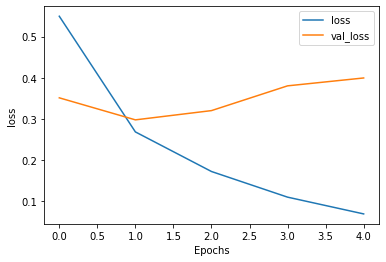

In [ ]:
plot_graphs(history,'loss')

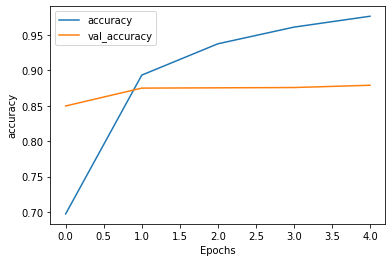

In [ ]:
plot_graphs(history,'accuracy')

[